In [ ]:
import torch.optim as optim
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec


from sklearn.cluster import DBSCAN, SpectralClustering, AgglomerativeClustering, BisectingKMeans
from sklearn.linear_model import RANSACRegressor
from tqdm import tqdm
import numpy as np
import itertools
from sklearn.linear_model import RANSACRegressor

import torch
import torch.nn as nn
import torch.nn.functional as F

import sys
sys.path.append('../.')

from Data.DataLoader import *

In [ ]:
# Load the model

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# load the data
train_loader, val_loader, test_loader, train_samples, train_labels, val_samples, val_labels, test_samples, test_labels = get_mnist_data_loaders(batch_size=64)

Train Loader Batch Shapes:
Batch 1: Images Shape = torch.Size([64, 1, 28, 28]), Labels Shape = torch.Size([64])

Validation Loader Batch Shapes:
Batch 1: Images Shape = torch.Size([64, 1, 28, 28]), Labels Shape = torch.Size([64])

Test Loader Batch Shapes:
Batch 1: Images Shape = torch.Size([64, 1, 28, 28]), Labels Shape = torch.Size([64])

Train Samples Shape: torch.Size([50000, 784])
Train Labels Shape: torch.Size([50000])

Validation Samples Shape: torch.Size([10000, 784])
Validation Labels Shape: torch.Size([10000])

Test Samples Shape: torch.Size([10000, 784])
Test Labels Shape: torch.Size([10000])

Train Label Frequencies: Counter({1: 5678, 7: 5175, 3: 5101, 9: 4988, 2: 4968, 6: 4951, 0: 4932, 4: 4859, 8: 4842, 5: 4506})
Validation Label Frequencies: Counter({7: 1090, 1: 1064, 3: 1030, 8: 1009, 0: 991, 2: 990, 4: 983, 6: 967, 9: 961, 5: 915})
Test Label Frequencies: Counter({1: 1135, 2: 1032, 7: 1028, 3: 1010, 9: 1009, 4: 982, 0: 980, 8: 974, 6: 958, 5: 892})


In [ ]:
class CNNModel(nn.Module):
    def __init__(self, dropout_prob=0.5):
        super(CNNModel, self).__init__()
        self.conv1 = nn.Conv2d(1, 32, kernel_size=3, padding=1)
        self.bn1 = nn.BatchNorm2d(32)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
        self.bn2 = nn.BatchNorm2d(64)
        self.conv3 = nn.Conv2d(64, 128, kernel_size=3, padding=1)
        self.bn3 = nn.BatchNorm2d(128)
        self.fc1 = nn.Linear(128 * 3 * 3, 256)
        self.fc2 = nn.Linear(256, 10)
        self.dropout = nn.Dropout(p=dropout_prob)

    def forward(self, x):
        # shape x : [b, 1, 28, 28]
        x = F.relu(self.bn1(self.conv1(x)))
        x = F.max_pool2d(x, 2) # max pooling with 2x2 kernel
        x = F.relu(self.bn2(self.conv2(x)))
        x = F.max_pool2d(x, 2)
        x = F.relu(self.bn3(self.conv3(x)))
        x = F.max_pool2d(x, 2)
        x = x.view(-1, 128 * 3 * 3)  # Flatten the tensor
        x = F.relu(self.fc1(x))
        x = self.dropout(x) # applied on 256 from fc1
        x = self.fc2(x) # classifies
        return x

In [ ]:
def train(model, device, train_loader, optimizer, epoch):
    model.train()
    for data, target in train_loader: # train_loader 50k shuffled data
        data, target = data.to(device), target.to(device) # batch size 64
        optimizer.zero_grad() # grad = o
        output = model(data) # torch: model calls forward
        loss = F.cross_entropy(output, target)
        loss.backward() # calculates grad
        optimizer.step() # updates weights w/ grad

def evaluate(model, device, data_loader): # accuracy
    model.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for data, target in data_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            _, predicted = torch.max(output, 1)
            total += target.size(0)
            correct += (predicted == target).5sum().item()
    accuracy = 100. * correct / total
    return accuracy

In [ ]:
epochs = 20
learning_rate = 0.01
momentum = 0.9
dropout_prob = 0.5
log_interval = 100

test_accuracy = []
train_accuracy = []
val_accuracy = []

dropout_rates = [0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 0.99]

In [ ]:

for dropout_prob in tqdm(dropout_rates):

    model = CNNModel(dropout_prob=dropout_prob).to(device)
    optimizer = optim.SGD(model.parameters(), lr=learning_rate, momentum=momentum)

    # Training loop
    for epoch in range(1, epochs + 1):
        train(model, device, train_loader, optimizer, epoch, log_interval)


    test_accuracy += [evaluate(model, device, test_loader)]
    train_accuracy += [evaluate(model, device, train_loader)]
    val_accuracy += [evaluate(model, device, val_loader)]


100%|██████████| 11/11 [1:01:04<00:00, 333.14s/it]


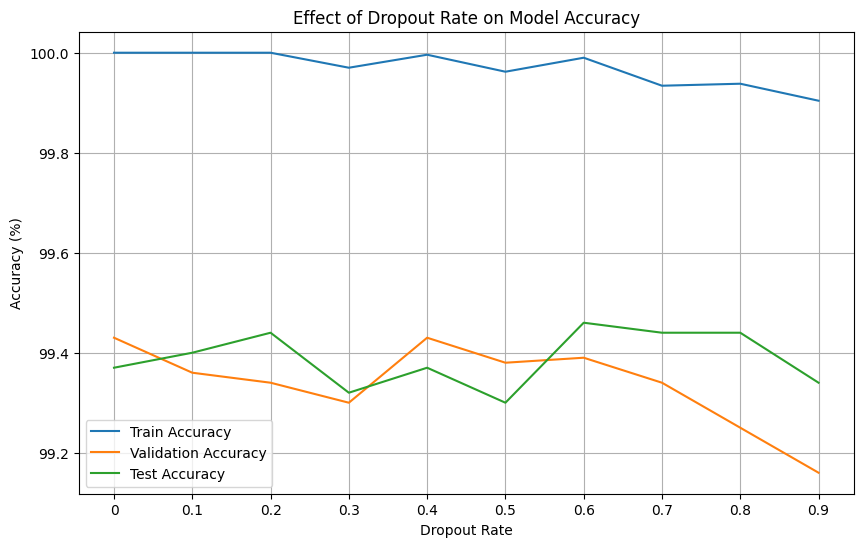

In [ ]:
# Visualization
plt.figure(figsize=(10, 6))
plt.plot(np.arange(len(dropout_rates[:-1])) + 1, train_accuracy[:-1], label='Train Accuracy')
plt.plot(np.arange(len(dropout_rates[:-1])) + 1, val_accuracy[:-1], label='Validation Accuracy')
plt.plot(np.arange(len(dropout_rates[:-1])) + 1, test_accuracy[:-1], label='Test Accuracy')
plt.xlabel('Dropout Rate')
plt.ylabel('Accuracy (%)')
plt.xticks(np.arange(len(dropout_rates[:-1])) + 1, dropout_rates[:-1])
plt.title('Effect of Dropout Rate on Model Accuracy')
plt.legend()
plt.grid(True)
plt.show()

In [ ]:
train_loader, val_loader, test_loader, train_samples, train_labels, val_samples, val_labels, test_samples, test_labels = get_cifar10_data_loaders()

100%|██████████| 170498071/170498071 [00:05<00:00, 28499398.97it/s]


Extracting ./data/cifar-10-python.tar.gz to ./data
Files already downloaded and verified
Train Loader Batch Shapes:
Batch 1: Images Shape = torch.Size([64, 3, 32, 32]), Labels Shape = torch.Size([64])

Validation Loader Batch Shapes:
Batch 1: Images Shape = torch.Size([64, 3, 32, 32]), Labels Shape = torch.Size([64])

Test Loader Batch Shapes:
Batch 1: Images Shape = torch.Size([64, 3, 32, 32]), Labels Shape = torch.Size([64])

Train Samples Shape: (40000, 32, 32, 3)
Train Labels Shape: torch.Size([40000])

Validation Samples Shape: (10000, 32, 32, 3)
Validation Labels Shape: torch.Size([10000])

Test Samples Shape: (10000, 32, 32, 3)
Test Labels Shape: torch.Size([10000])

Train Label Frequencies: Counter({2: 4048, 7: 4023, 6: 4020, 4: 4003, 8: 3997, 1: 3986, 0: 3986, 3: 3984, 9: 3978, 5: 3975})
Validation Label Frequencies: Counter({5: 1025, 9: 1022, 3: 1016, 1: 1014, 0: 1014, 8: 1003, 4: 997, 6: 980, 7: 977, 2: 952})
Test Label Frequencies: Counter({3: 1000, 8: 1000, 0: 1000, 6: 100

In [ ]:
class CNNModel_c(nn.Module):
    def __init__(self, dropout_prob=0.5):
        super(CNNModel_c, self).__init__()
        self.conv1 = nn.Conv2d(3, 32, kernel_size=3, padding=1)
        self.bn1 = nn.BatchNorm2d(32)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
        self.bn2 = nn.BatchNorm2d(64)
        self.conv3 = nn.Conv2d(64, 128, kernel_size=3, padding=1)
        self.bn3 = nn.BatchNorm2d(128)
        self.conv4 = nn.Conv2d(128, 128, kernel_size=3, padding=1)
        self.bn4 = nn.BatchNorm2d(128)
        self.fc1 = nn.Linear(128 * 2 * 2, 256)
        self.fc2 = nn.Linear(256, 10)
        self.dropout = nn.Dropout(p=dropout_prob)

    def forward(self, x):
        x = F.relu(self.bn1(self.conv1(x)))
        x = F.max_pool2d(x, 2)
        x = F.relu(self.bn2(self.conv2(x)))
        x = F.max_pool2d(x, 2)
        x = F.relu(self.bn3(self.conv3(x)))
        x = F.max_pool2d(x, 2)
        x = F.relu(self.bn4(self.conv4(x)))
        x = F.max_pool2d(x, 2)
        x = x.view(-1, 128 * 2 * 2)
        x = F.relu(self.fc1(x))
        x = self.dropout(x)
        x = self.fc2(x)
        return x

In [ ]:
test_accuracy_cifar = []
train_accuracy_cifar = []
val_accuracy_cifar = []

for dropout_prob in tqdm(dropout_rates):

    model = CNNModel_c(dropout_prob=dropout_prob).to(device)
    optimizer = optim.SGD(model.parameters(), lr=learning_rate, momentum=momentum)

    # Training loop
    for epoch in range(1, epochs + 1):
        train(model, device, train_loader, optimizer, epoch, log_interval)


    test_accuracy_cifar += [evaluate(model, device, test_loader)]
    train_accuracy_cifar += [evaluate(model, device, train_loader)]
    val_accuracy_cifar += [evaluate(model, device, val_loader)]

100%|██████████| 11/11 [57:04<00:00, 311.33s/it]


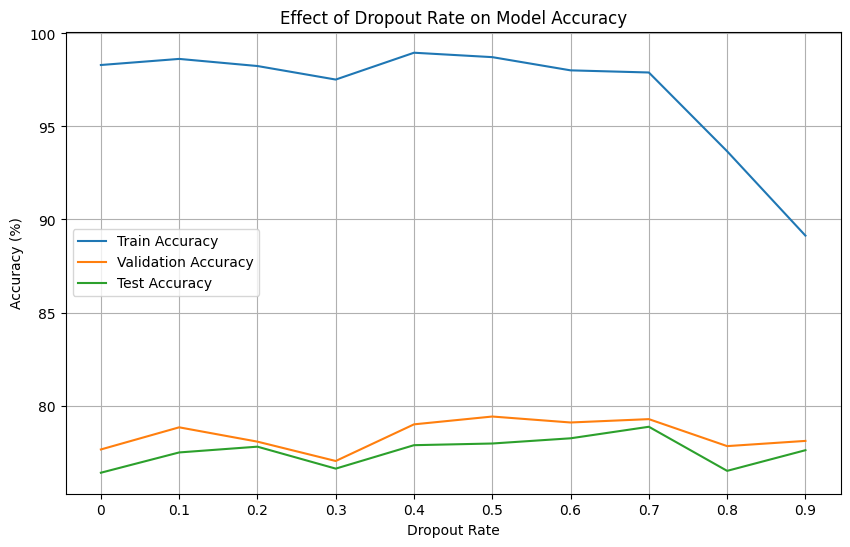

In [ ]:
# Visualization
plt.figure(figsize=(10, 6))
plt.plot(np.arange(len(dropout_rates[:-1])) + 1, train_accuracy_cifar[:-1], label='Train Accuracy')
plt.plot(np.arange(len(dropout_rates[:-1])) + 1, val_accuracy_cifar[:-1], label='Validation Accuracy')
plt.plot(np.arange(len(dropout_rates[:-1])) + 1, test_accuracy_cifar[:-1], label='Test Accuracy')
plt.xlabel('Dropout Rate')
plt.ylabel('Accuracy (%)')
plt.xticks(np.arange(len(dropout_rates[:-1])) + 1, dropout_rates[:-1])
plt.title('Effect of Dropout Rate on Model Accuracy')
plt.legend()
plt.grid(True)
plt.show()